<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/5.%201Q%20DD%20(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [2]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 17.6 MB/s eta 0:00:00


In [3]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# CP CPMG UDD XY4 XY8 XY16 Sequence

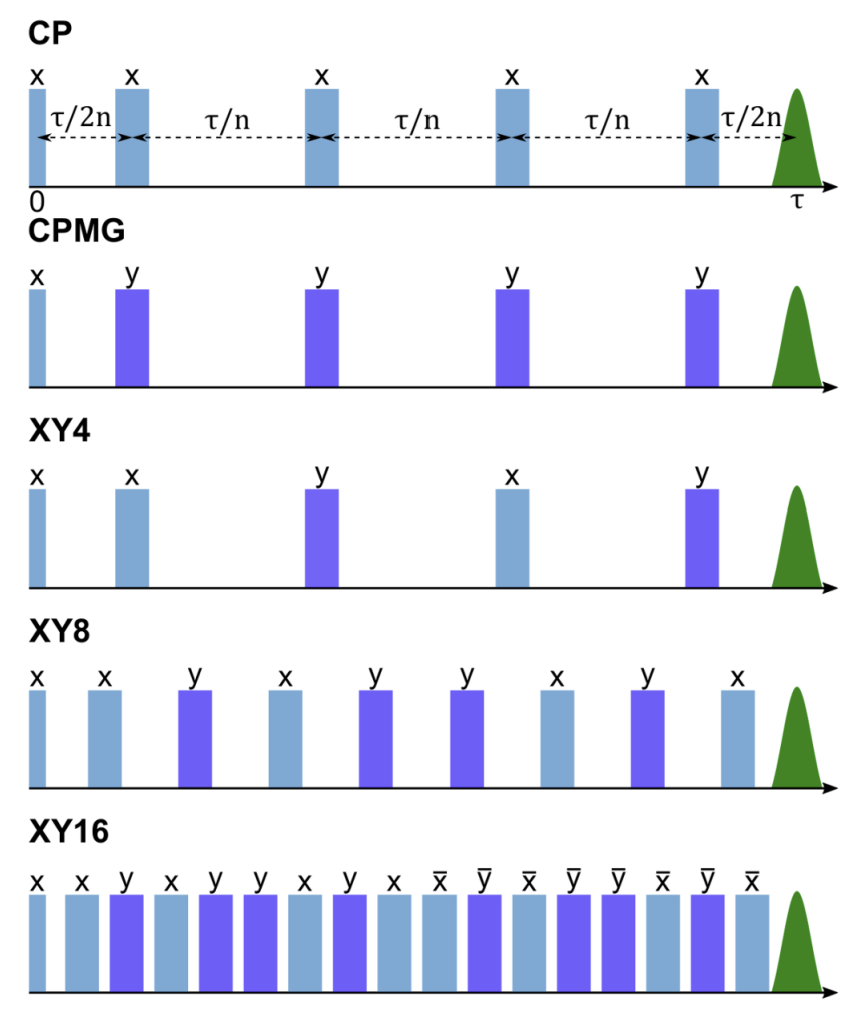

In [4]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [5]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [6]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

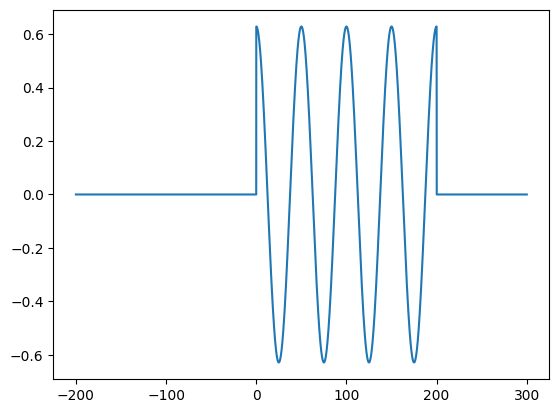

In [7]:
# resonator drive pulse simulation

tlist = np.linspace(-200, 300, 10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': 0, 'T_end_r': 200, 'Omega_rd': 2*np.pi*0.02}))

## CP CPMG UDD Sequence

In [8]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [9]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [10]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

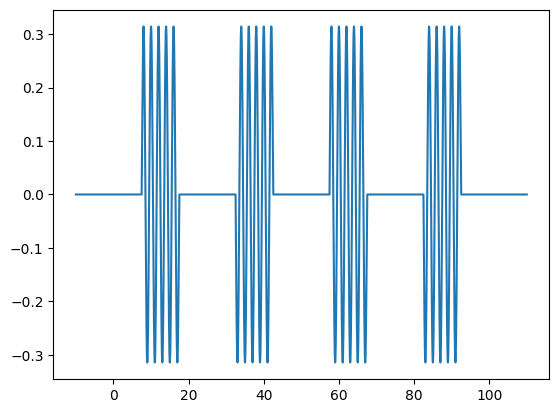

In [11]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

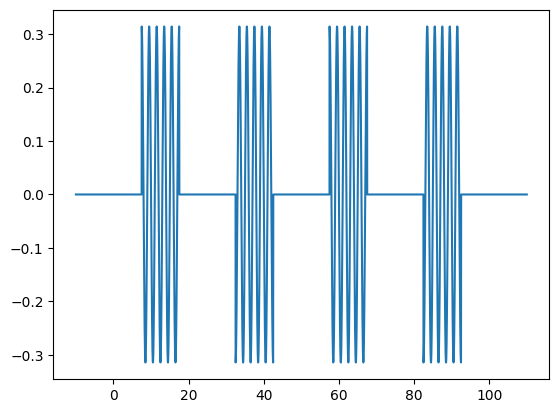

In [12]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

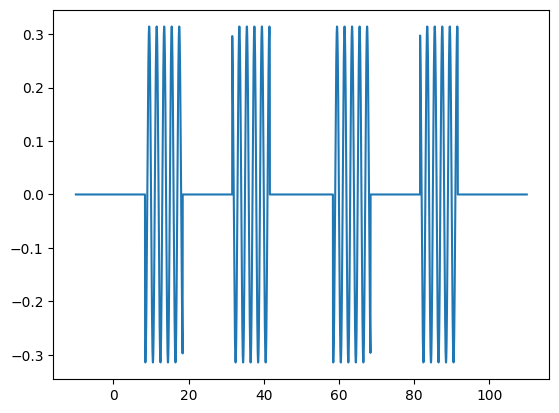

In [13]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

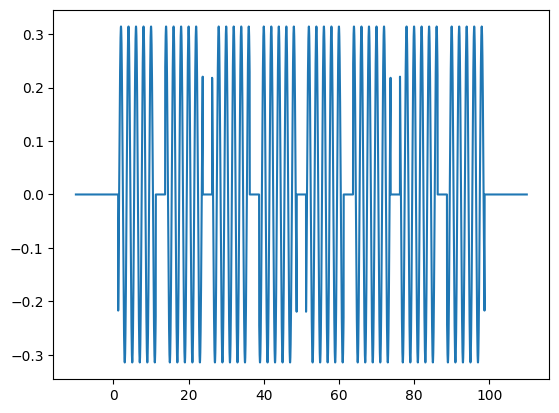

In [14]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

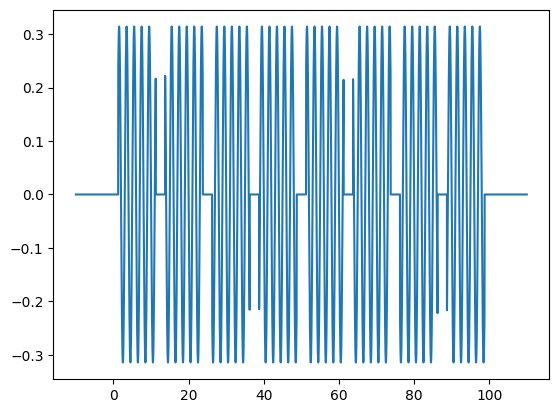

In [15]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

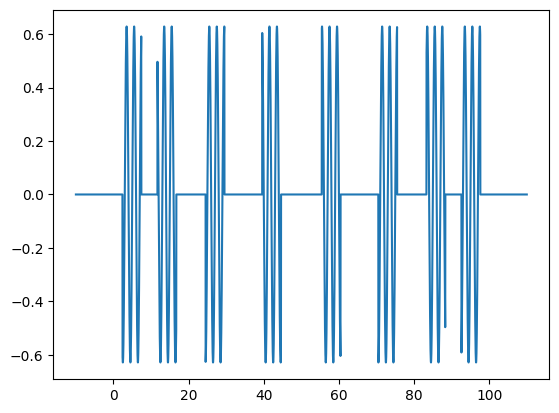

In [16]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

## XY4 XY8 XY16 Sequence

In [17]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [18]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [19]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

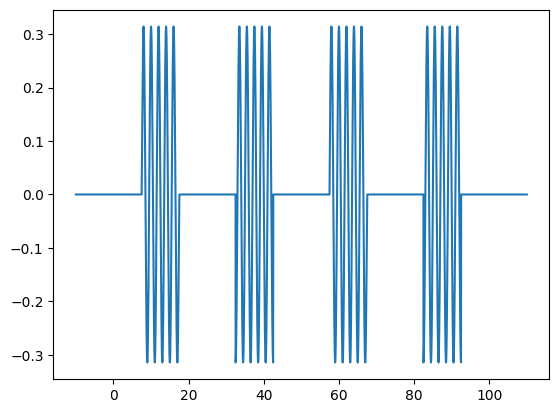

In [20]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

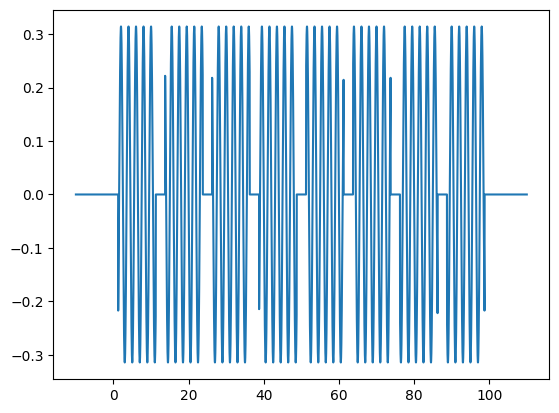

In [21]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY8_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

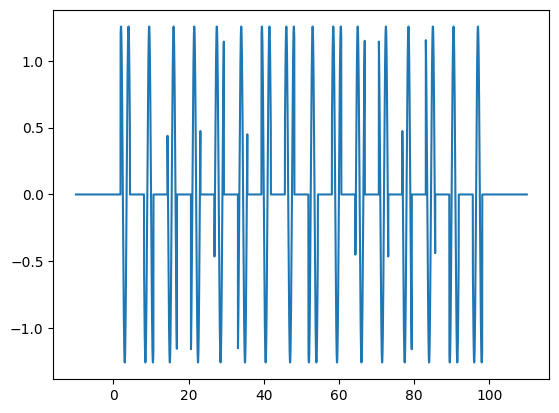

In [22]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

## UDD4 UDD8 UDD16 Sequence

In [23]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [24]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [25]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

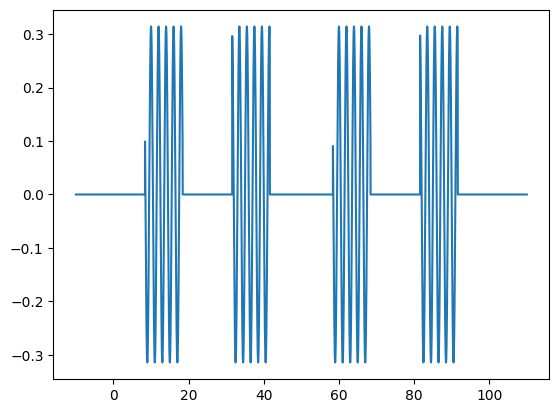

In [26]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

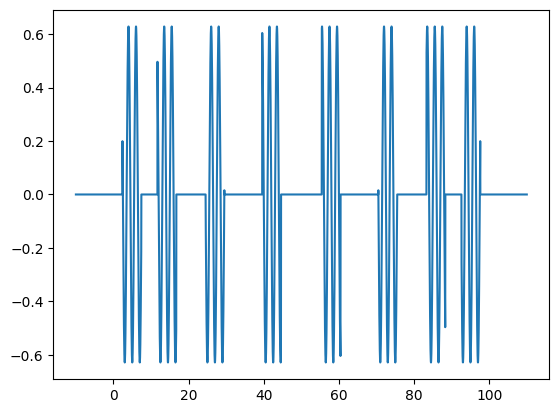

In [27]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD8_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

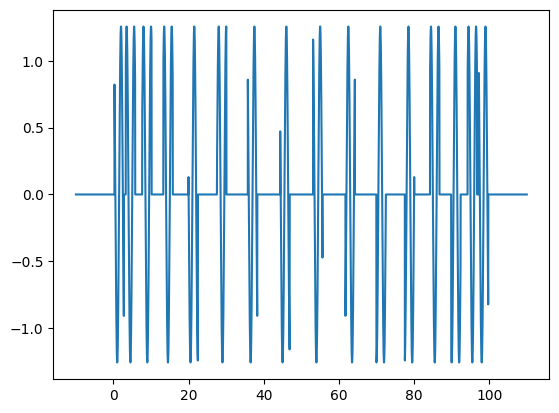

In [28]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

# Goal of this paper

Goal : Investigate the effect of dynamical decoupling

Total evolution time : 500ns, 1000ns

Condition 1 : large photon number regime $ n = 0.005 $

Condition 2 : without Purcell Filter

# Dynamical Decoupling Simulation

$ \omega_{qd} = \omega_q^b + \chi $

Evolution time 500ns

## Ramsey

In [37]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q + chi      # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 5000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

A = 0.00001 * 2 * np.pi
B = 0.1 * 2 * np.pi

coherence_list = []

In [38]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.004349947554406079


Text(0, 0.5, 'Z Expectation Value')

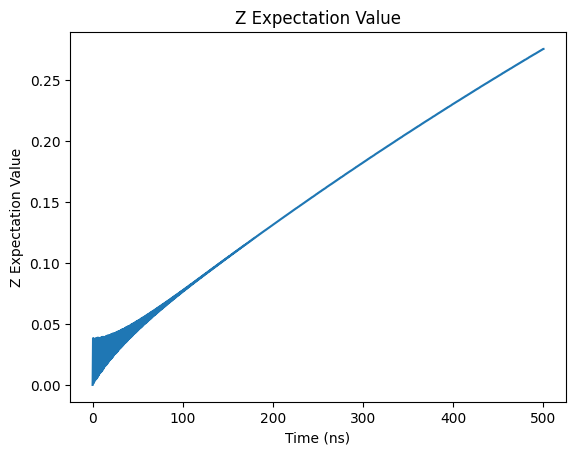

In [39]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [40]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.68562788e-01,  9.87816399e-01,  1.62417471e+03])

Measured $ T_1 = 1.5785 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

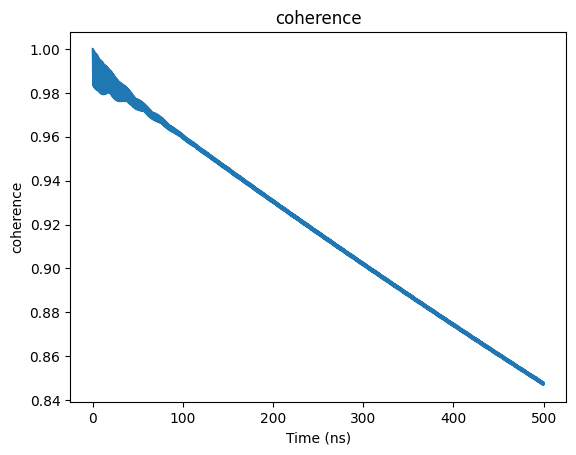

In [41]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

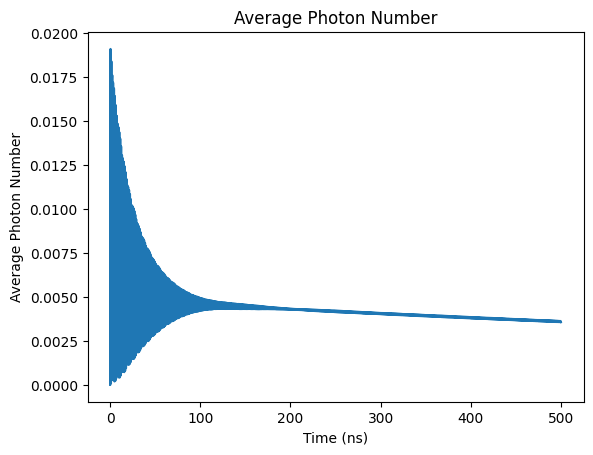

In [42]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

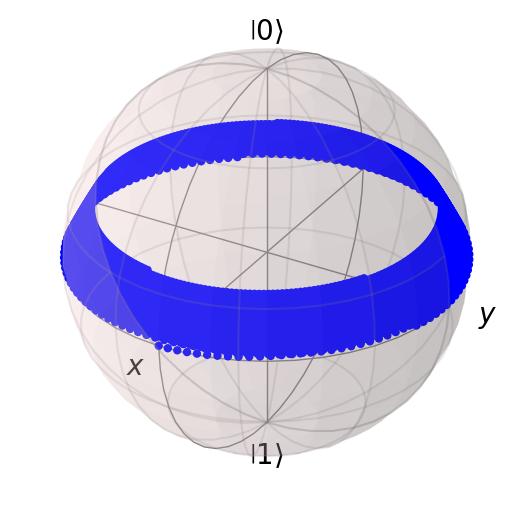

In [43]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [44]:
coherence_list.append(2*np.abs(result.expect[3][-1]))